4/4 [==============================] - 0s 4ms/step


4/4 [==============================] - 0s 3ms/step
Epoch 0 - Discriminator Loss: 0.4047597050666809, Generator Loss: 1.641114354133606
4/4 [==============================] - 0s 4ms/step
Epoch 1 - Discriminator Loss: 0.3572688400745392, Generator Loss: 1.7281520366668701
4/4 [==============================] - 0s 2ms/step
Epoch 2 - Discriminator Loss: 0.37717360258102417, Generator Loss: 2.3122200965881348
4/4 [==============================] - 0s 4ms/step
Epoch 3 - Discriminator Loss: 0.6757938861846924, Generator Loss: 0.8232839107513428
4/4 [==============================] - 0s 3ms/step
Epoch 4 - Discriminator Loss: 0.49571847915649414, Generator Loss: 1.5459543466567993
4/4 [==============================] - 0s 3ms/step
Epoch 5 - Discriminator Loss: 0.5466107130050659, Generator Loss: 1.4323782920837402
4/4 [==============================] - 0s 3ms/step
Epoch 6 - Discriminator Loss: 0.5695641040802002, Generator Loss: 1.82516384124

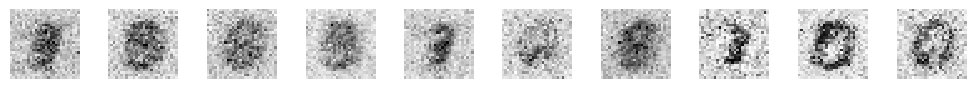

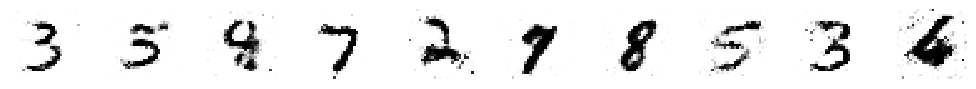

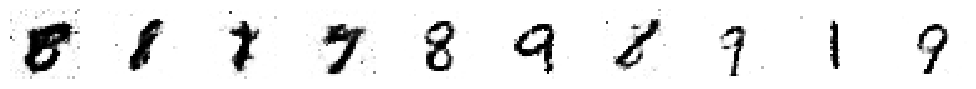

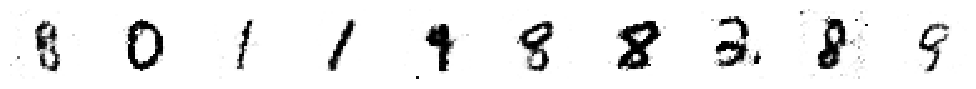

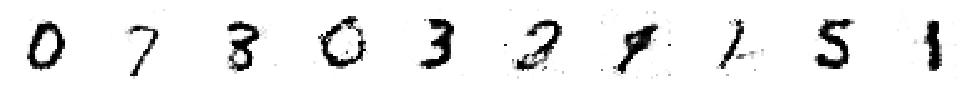

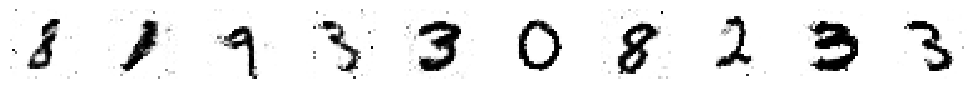

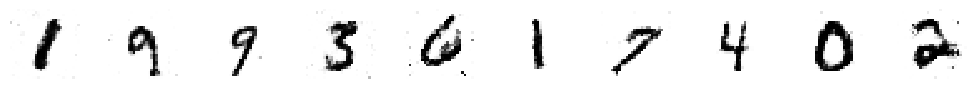

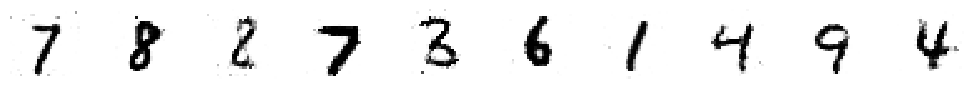

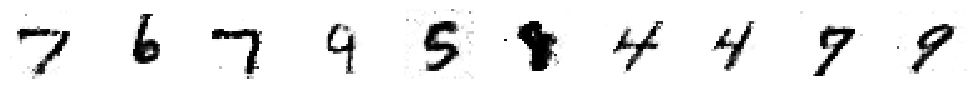

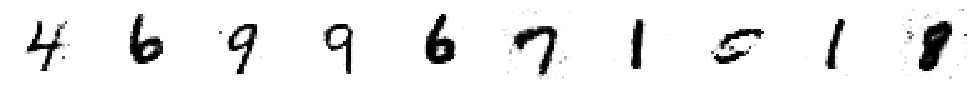

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, LeakyReLU, BatchNormalization, Reshape, Flatten, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import initializers

# Set random seed for reproducibility
np.random.seed(1000)

# Define the generator model
def build_generator(latent_dim):
    model = Sequential()

    model.add(Dense(256, input_dim=latent_dim, kernel_initializer=initializers.RandomNormal(stddev=0.02)))
    model.add(LeakyReLU(alpha=0.2))
    model.add(BatchNormalization(momentum=0.8))

    model.add(Dense(512))
    model.add(LeakyReLU(alpha=0.2))
    model.add(BatchNormalization(momentum=0.8))

    model.add(Dense(1024))
    model.add(LeakyReLU(alpha=0.2))
    model.add(BatchNormalization(momentum=0.8))

    model.add(Dense(784, activation='tanh'))
    model.add(Reshape((28, 28, 1)))

    return model

# Define the discriminator model
def build_discriminator(img_shape):
    model = Sequential()

    model.add(Flatten(input_shape=img_shape))

    model.add(Dense(1024, kernel_initializer=initializers.RandomNormal(stddev=0.02)))
    model.add(LeakyReLU(alpha=0.2))

    model.add(Dense(512))
    model.add(LeakyReLU(alpha=0.2))

    model.add(Dense(256))
    model.add(LeakyReLU(alpha=0.2))

    model.add(Dense(1, activation='sigmoid'))

    return model

# Build and compile the discriminator
img_shape = (28, 28, 1)
discriminator = build_discriminator(img_shape)
discriminator.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.0002, beta_1=0.5), metrics=['accuracy'])

# Build the generator
latent_dim = 100
generator = build_generator(latent_dim)

# Build the GAN model
discriminator.trainable = False
gan_input = Input(shape=(latent_dim,))
x = generator(gan_input)
gan_output = discriminator(x)
gan = Model(gan_input, gan_output)
gan.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.0002, beta_1=0.5))

# Function to train the GAN
def train_gan(epochs=1, batch_size=128):
    # Load and normalize the MNIST dataset
    (X_train, _), (_, _) = mnist.load_data()
    X_train = (X_train.astype(np.float32) - 127.5) / 127.5
    X_train = X_train.reshape(X_train.shape[0], 28, 28, 1)

    batch_count = X_train.shape[0] // batch_size

    for e in range(epochs):
        for _ in range(batch_count):
            noise = np.random.normal(0, 1, size=[batch_size, latent_dim])
            generated_images = generator.predict(noise)
            image_batch = X_train[np.random.randint(0, X_train.shape[0], size=batch_size)]

            X = np.concatenate([image_batch, generated_images])
            y_dis = np.zeros(2 * batch_size)
            y_dis[:batch_size] = 0.9  # Label smoothing

            discriminator.trainable = True
            d_loss = discriminator.train_on_batch(X, y_dis)

            noise = np.random.normal(0, 1, size=[batch_size, latent_dim])
            y_gen = np.ones(batch_size)
            discriminator.trainable = False
            g_loss = gan.train_on_batch(noise, y_gen)

        print(f"Epoch {e} - Discriminator Loss: {d_loss[0]}, Generator Loss: {g_loss}")

        # Save generated images at specified intervals
        if e % 10 == 0:
            plot_generated_images(e, generator)

# Function to plot generated images
def plot_generated_images(epoch, generator, examples=10, dim=(1, 10), figsize=(10, 1)):
    noise = np.random.normal(0, 1, size=[examples, latent_dim])
    generated_images = generator.predict(noise)
    generated_images = generated_images.reshape(examples, 28, 28)

    plt.figure(figsize=figsize)
    for i in range(generated_images.shape[0]):
        plt.subplot(dim[0], dim[1], i+1)
        plt.imshow(generated_images[i], interpolation='nearest', cmap='gray_r')
        plt.axis('off')

    plt.tight_layout()
    plt.savefig(f"gan_generated_image_epoch_{epoch}.png")

# Train the GAN
train_gan(epochs=100, batch_size=128)
